In [1]:
import xarray as xr
import pandas as pd
import geopandas as gpd
from shapely.geometry import box
import numpy as np
import h5py
from fft_unwrap import unwrap_phase_fft
import matplotlib.pyplot as plt
import contextily as ctx

In [2]:
%%time
# load in our wrapped phase data
# NOTE: these are NASA OPERA CSLC products, same Sentinel-1 burst 12 days apart
# coregistered and corrected for topographic, atmospheric, orbital, and random phase noise
fn_1 = "/home/jehayes/gda_final/opera/cslc/OPERA_L2_CSLC-S1_T087-185682-IW1_20180809T161540Z_20240428T125546Z_S1B_VV_v1.1.h5"
fn_2 = "/home/jehayes/gda_final/opera/cslc/OPERA_L2_CSLC-S1_T087-185682-IW1_20180815T161623Z_20240428T143339Z_S1A_VV_v1.1.h5"

dsR = xr.open_dataset(fn_1,
                      group='data',
                      engine='h5netcdf')['VV'].rename(dict(x_coordinates='x', y_coordinates='y'))
tR = pd.to_datetime(xr.open_dataset(fn_1, 
                                    group='identification')['zero_doppler_start_time'].data.astype('U')) # Unicode string format
dsS = xr.open_dataset(fn_2,
                      group='data',
                      engine='h5netcdf')['VV'].rename(dict(x_coordinates='x', y_coordinates='y'))

tS = pd.to_datetime(xr.open_dataset(fn_2, group='identification')['zero_doppler_start_time'].data.astype('U'))

ifg = dsR * np.conj(dsS)
ifg.attrs['reference'] = tR
ifg.attrs['secondary'] = tS
da = xr.apply_ufunc(np.angle, ifg)
ds = da.to_dataset(name='phase')

with h5py.File(fn_1, 'r') as f:
    proj_ds = f['/data/projection']
    proj_value = proj_ds[()]
    print("Projection:", proj_value)
    for key, value in proj_ds.attrs.items():
        print(f"{key}: {value}")

ds.rio.write_crs(proj_value, inplace=True)

Projection: 32605
description: b'Projection system'
ellipsoid: b'WGS84'
epsg_code: 32605
grid_mapping_name: b'universal_transverse_mercator'
inverse_flattening: 298.257223563
semi_major_axis: 6378137.0
spatial_ref: b'PROJCS["WGS 84 / UTM zone 5N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-153],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32605"]]'
utm_zone_number: 5
CPU times: user 8.28 s, sys: 1.74 s, total: 10 s
Wall time: 10.3 s


<xarray.Dataset> Size: 393MB
Dimensions:      (x: 19830, y: 4950)
Coordinates:
  * x            (x) float64 159kB 2.487e+05 2.487e+05 ... 3.478e+05 3.478e+05
  * y            (y) float64 40kB 2.18e+06 2.18e+06 ... 2.13e+06 2.13e+06
    spatial_ref  int64 8B 0
Data variables:
    phase        (y, x) float32 393MB nan nan nan nan nan ... nan nan nan nan

In [3]:
%%time
# option to coarsen, but we won't
nx = 1
ny = 1
wrapped_phase_da = ds.phase.coarsen(x=nx, y=ny, boundary='trim').mean()
wrapped_phase_np = wrapped_phase_da.values
# Unwrap the phase using our custom FFT-based function
unwrapped_np = unwrap_phase_fft(wrapped_phase_np)
# Convert back to an xarray DataArray with matching coordinates
unwrapped_da = xr.DataArray(unwrapped_np, dims=wrapped_phase_da.dims, coords=wrapped_phase_da.coords)
ds_unwrapped = unwrapped_da.to_dataset(name='unwrapped_phase')

CPU times: user 41.1 s, sys: 8.49 s, total: 49.6 s
Wall time: 49.5 s


In [4]:
# mask out based on original array since we fill in the masked values in our unwrap func
unwrapped_da = unwrapped_da.where(~np.isnan(ds.phase))

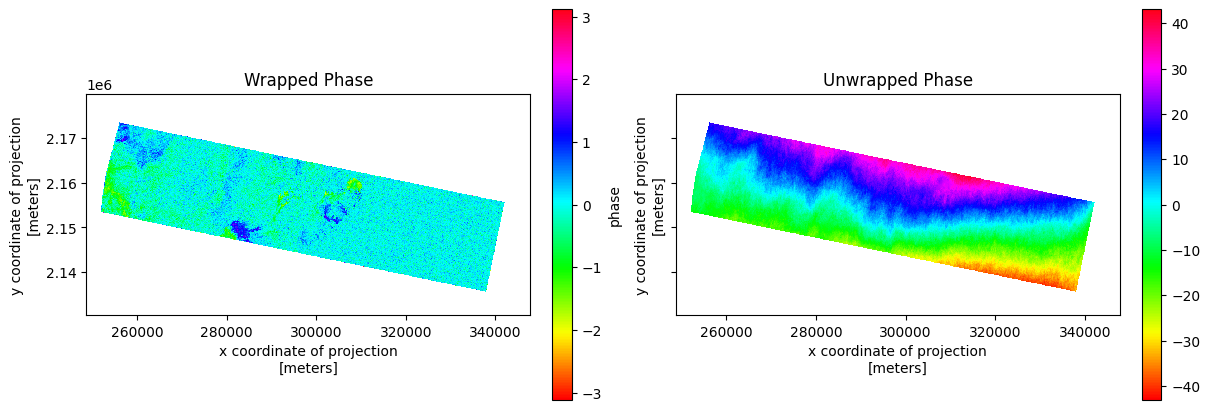

In [5]:
nx = 16
ny = 8
f, axs = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True, sharex=True, sharey=True)

ds.phase.coarsen(x=nx, y=ny, boundary='trim').mean().plot.imshow(cmap='hsv', ax=axs[0])
axs[0].set_title('Wrapped Phase')

unwrapped_da.coarsen(x=nx, y=ny, boundary='trim').mean().plot.imshow(cmap='hsv', ax=axs[1])
axs[1].set_title('Unwrapped Phase')

for ax in axs:
    ax.set_aspect('equal')

plt.show()

In [7]:
import rasterio.features
import shapely.geometry
import shapely.ops

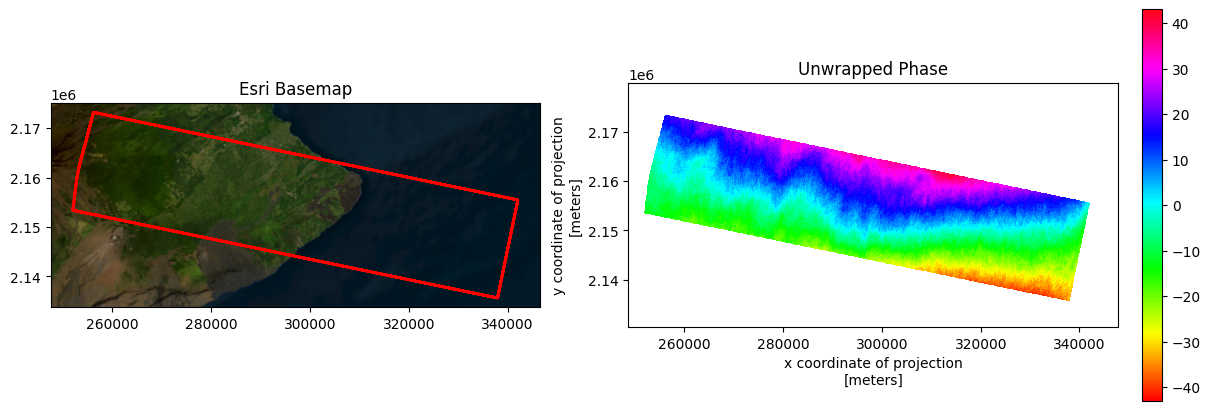

In [9]:
f, axs = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)

mask = np.where(np.isnan(unwrapped_da.values), 0, 1).astype(np.uint8)
transform = unwrapped_da.rio.transform()
shapes_gen = rasterio.features.shapes(mask, transform=transform)
polygon = [shapely.geometry.shape(shape) for shape, value in shapes_gen if value == 1]
gf_burst = gpd.GeoDataFrame(geometry=polygon, crs=unwrapped_da.rio.crs)
gf_burst.plot(ax=axs[0], facecolor='none', 
              edgecolor='red', linewidth=2)

ctx.add_basemap(
    axs[0],
    crs=unwrapped_da.rio.crs,
    source=ctx.providers.Esri.WorldImagery,
    attribution=False
)
axs[0].set_title('Esri Basemap')

unwrapped_da.coarsen(x=nx, y=ny, boundary='trim').mean().plot.imshow(cmap='hsv', ax=axs[1])
axs[1].set_title('Unwrapped Phase')

for ax in axs:
    ax.set_aspect('equal')

plt.show()